In [1]:
from scripts.pypsa_curtailment_emulator import *
from scripts.plotting import mesh_color_2
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
fs = 15
plt.style.use('seaborn-ticks')
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['axes.axisbelow'] = True

Explore which scenarios are available:

In [3]:
RDIR = "calculated_metrics" # directory with the results of the PyPSA runs (.csv files)

scens_list = [x for x in os.listdir(RDIR + '/') if x.startswith("new_")]
print(scens_list)

['new_base', 'new_base_co2_lim', 'new_flipped_merit_order', 'new_full_sectors', 'new_full_sectors_SDES', 'new_full_sectors_SDES_LDES', 'new_H2_demand', 'new_H2_demand_co2_lim', 'new_heating_demand', 'new_heating_demand_co2_lim', 'new_LDES', 'new_LDES_co2_lim', 'new_SDES', 'new_SDES_co2_lim', 'new_SDES_LDES', 'new_SDES_LDES_co2_lim', 'new_transmission', 'new_transmission_co2_lim', 'new_transmission_SDES', 'new_transmission_SDES_co2_lim', 'new_transmission_SDES_LDES', 'new_transmission_SDES_LDES_co2_lim', 'new_transport', 'new_transport_co2_lim']


Group scenarios by category:

In [4]:
scens_series = pd.Series(scens_list)

#¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ power system ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

# scenarios that allow for transmission expansion:
scens_w_transmission = scens_series.loc[scens_series.str.contains("transmission")].to_list()

# scenarios that allow for long-duration storage deployment: 
scens_w_ldes = scens_series.loc[scens_series.str.contains("LDES")].to_list()

# scenarios that allow for short-duration storage deployment:
scens_w_sdes = scens_series.loc[scens_series.str.contains("SDES")].to_list()

#¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ sector-coupling ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

# scenarios that allow for sector-coupling with the heating sector:
scens_w_heating = scens_series.loc[scens_series.str.contains("heating")].to_list()

# scenarios that allow for sector-coupling with the land transport sector:
scens_w_transport = scens_series.loc[scens_series.str.contains("transport")].to_list()

# scenarios that allow for sector-coupling with the industry sector:
scens_w_industry = scens_series.loc[scens_series.str.contains("industry")].to_list()

print("scenarios with SDES: ", scens_w_sdes)
print("scenarios with LDES: ", scens_w_ldes)

scenarios with SDES:  ['new_full_sectors_SDES', 'new_full_sectors_SDES_LDES', 'new_SDES', 'new_SDES_co2_lim', 'new_SDES_LDES', 'new_SDES_LDES_co2_lim', 'new_transmission_SDES', 'new_transmission_SDES_co2_lim', 'new_transmission_SDES_LDES', 'new_transmission_SDES_LDES_co2_lim']
scenarios with LDES:  ['new_full_sectors_SDES_LDES', 'new_LDES', 'new_LDES_co2_lim', 'new_SDES_LDES', 'new_SDES_LDES_co2_lim', 'new_transmission_SDES_LDES', 'new_transmission_SDES_LDES_co2_lim']


# **Creating the PyPSA Curtailment Emulator**

Here, we read the Excel file that contains the 34 relations (constraints) of which the sum corresponds to the renewable curtailment at a given share of wind, solar, battery, and long-duration energy storage. 

First, we will update the parameters. We can do this, making the parameterization dependent on a scenario with or without a CO2 emissions limit ("new_base" and "new_base_co2_lim").

In [5]:
file_path = 'data/PyPSA_curtailment_emulator.xlsx' # location of pypsa emulator excel file
base_case = "new_base_co2_lim" # name of base curtailment scenario
SDES_case = "new_SDES_co2_lim" # name of the scenario representing the curtailment impact of SDES
LDES_case = "new_SDES_LDES_co2_lim" # name of the scenario representing the curtailment impact of LDES

You can also skip this cell, if you are satisfied with the set of parameters as it currently is, by setting the "update_parameters" to False.


In [6]:
update_parameters = True

if update_parameters:
    create_emulator(base_case, SDES_case, LDES_case, RDIR, file_path) # updates the excel file with the results of the PyPSA runs 

Wind curtailment successfully parameterized! Proceeding to solar curtailment...
Solar curtailment successfully parameterized! Proceeding to technology term...
LDES impact successfully parameterized! Proceeding to SDES...
SDES impact successfully parameterized!
Parameterization done!


# **Testing the PyPSA Curtailment Emulator**

Define the scenario for the estimation of the curtialment based on the renewable penetration of wind energy and solar PV, as well as the level of storage dispatch from short-duration (SDES) and long-duration energy storage (LDES). 

Note that the current version of this repository uses an Excel sheet which might lead to long computation time since it reads and writes to the file in every iteration.

In [30]:
wind_res = [10,20,30,40,50,60,70,80,90]
solar_res = [10,20,30,40,50,60,70,80,90]
N = len(wind_res)*len(solar_res)
ldes = 0
sdes = 5
curtailment_type="resources"

results_path = "results/"
filename_wind = "wind_curtailment_ldes" + str(ldes) + "_sdes" + str(sdes) + "_N" + str(N) + "_" + base_case + "_" + curtailment_type + "_series.csv"
filename_solar = "solar_curtailment_ldes" + str(ldes) + "_sdes" + str(sdes) + "_N" + str(N) + "_" + base_case + "_" + curtailment_type + "_series.csv"

if os.path.isfile(results_path + filename_wind):
    print("Files exist. Reading .csv files...")
    wind_curtailment_series = pd.read_csv(results_path + filename_wind, index_col=[0,1])["0"]
    solar_curtailment_series = pd.read_csv(results_path + filename_solar, index_col=[0,1])["0"]
    print("done.")
else:
    print("Files do not exist. Creating new .csv files...")
    wind_curtailment_series, solar_curtailment_series = test_pypsa_emulator(file_path, 
                                                                            wind_res,solar_res,ldes,sdes, 
                                                                            curtailment_type=curtailment_type)
    
    wind_curtailment_series.to_csv("results/" + filename_wind)
    solar_curtailment_series.to_csv("results/" + filename_solar)
    print("done.")

Files do not exist. Creating new .csv files...
estimated timing:  4.5  minute
done.


# Visualize the estimated curtailment levels from the emulator

In [9]:
color_max_value = 70

Wind:

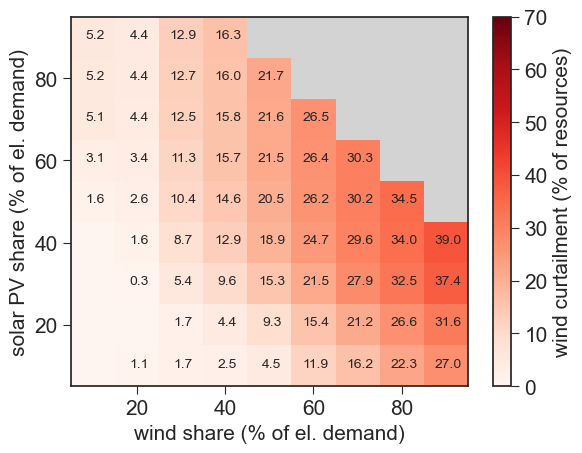

In [31]:
fig1, ax1, df1 = color_plot_2D(wind_curtailment_series, 
                               renewable = "wind", 
                               vmax = color_max_value,
                               cbar_label=curtailment_type)

fig1.savefig("figures/wind/wind_curtailment_ldes" + str(ldes) + "_sdes" + str(sdes) + "_N" + str(N) + "_" + base_case + "_" + curtailment_type + ".png",
                bbox_inches="tight",
                dpi=300)

Solar:

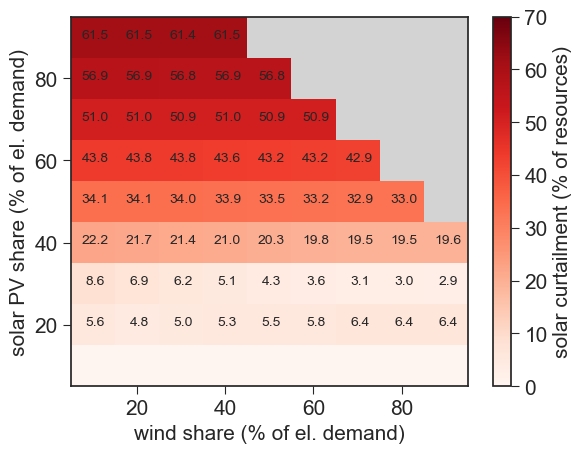

In [32]:
fig1, ax1, df1 = color_plot_2D(solar_curtailment_series, 
                               renewable = "solar", 
                               vmax = color_max_value,
                               cbar_label=curtailment_type)

fig1.savefig("figures/solar/solar_curtailment_ldes" + str(ldes) + "_sdes" + str(sdes) + "_N" + str(N) + "_" + base_case + "_" + curtailment_type + ".png",
                bbox_inches="tight",
                dpi=300)

# Compare with the observed values in PyPSA-Eur

Here, if you choose to include the impact of storage, the results are not directly comparable with the results obtained in PyPSA-Eur. This is because, the storage capacity were optimally selected in every wind-solar combination, and the storage capacity is not linear proportional to the penetration renewable level. In the above test case, you can only select a constant storage size which applies to all wind-solar combinations.

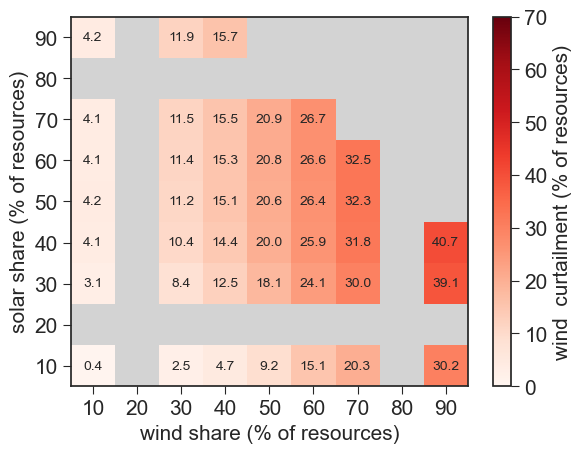

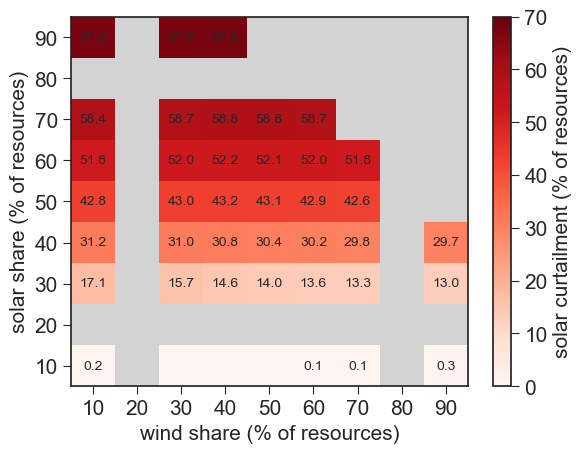

In [28]:
scens = [base_case]

variables = {"read":["wind curt", 
                    "solar curt",
                    "total demand"],
            "plot":["wind curt",
                    "solar curt"]}

df_pypsa, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=False,
                              equidistant=True,
                              )

figs[base_case,0].savefig("figures/wind/model_wind_curtailment_base_case_resources.png",
                bbox_inches="tight",
                dpi=300)

figs[base_case,1].savefig("figures/solar/model_solar_curtailment_base_case_resources.png",
                bbox_inches="tight",
                dpi=300)

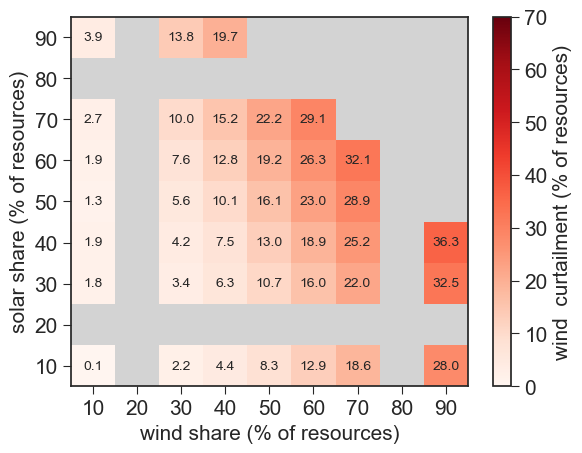

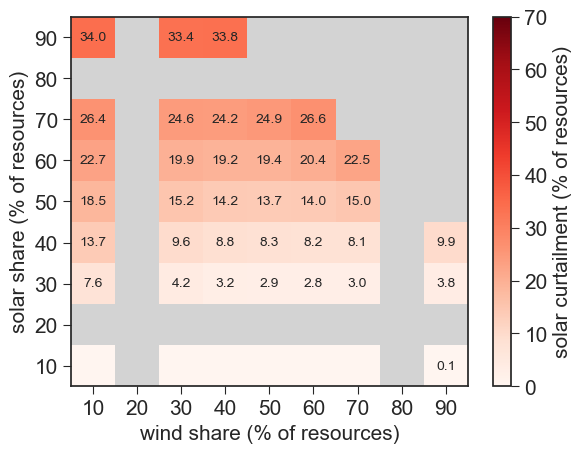

In [24]:
scens = [SDES_case]

variables = {"read":["wind curt", 
                    "solar curt",
                    "total demand"],
            "plot":["wind curt",
                    "solar curt"]}

df_pypsa, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=False,
                              equidistant=True,
                              )

figs[SDES_case,0].savefig("figures/wind/model_wind_curtailment_SDES_case.png",
                bbox_inches="tight",
                dpi=300)

figs[SDES_case,1].savefig("figures/solar/model_solar_curtailment_SDES_case.png",
                bbox_inches="tight",
                dpi=300)

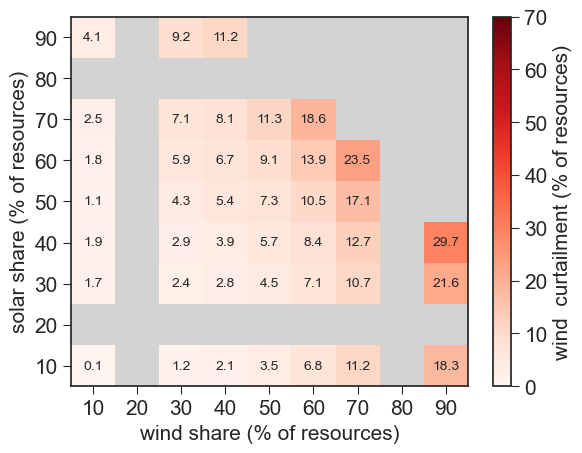

In [29]:
scens = [LDES_case]

variables = {"read":["wind curt", 
                #     "solar curt",
                    "total demand"],
            "plot":["wind curt",
                #     "solar curt",
                    ]}

df_pypsa, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=False,
                              equidistant=True,
                              )

figs[LDES_case,0].savefig("figures/wind/model_wind_curtailment_LDES_case.png",
                bbox_inches="tight",
                dpi=300)

Example of how curtailment is calculated with the marginal curtailment rates using a bi-linear interpolation:

In [318]:
solar_res_test = 40
wind_res_test = 10

wind_base = {10:0.037,
             30:0.764,
             40:1.870,
             }

f_AB0 = (0.314 - 0.037)/20 # solar step 1 (10% to 30%) at 10% wind
f_AC0 = (0.412 - 0.314)/10 # solar step 2 (30% to 40%) at 10% wind
f_AD0 = (0.422 - 0.412)/10 # solar step 3 (40% to 50%) at 10% wind
f_AE0 = (0.407 - 0.422)/10 # solar step 3 (50% to 60%) at 10% wind

f_AB1 = (2.523 - 0.764)/20 # solar step 1 at 30% wind
f_AC1 = (3.132 - 2.523)/10 # solar step 2 at 30% wind
f_AD1 = (3.353 - 3.132)/10 # solar step 3 at 30% wind 
f_AE1 = (3.422 - 3.353)/10 # solar step 3 at 30% wind 

f_AB2 = (4.993 - 1.870)/20 # solar step 1 at 40% wind
f_AC2 = (5.765 - 4.993)/10 # solar step 2 at 40% wind
f_AD2 = (6.031 - 5.765)/10 # solar step 3 at 40% wind
f_AE2 = (6.122 - 6.031)/10 # solar step 3 at 40% wind

marg_01 = f_AB0 # marginal curtailment rate 1
marg_02 = f_AC0 - f_AB0 # marginal curtailment rate 2
marg_03 = f_AD0 - f_AC0 # marginal curtailment rate 3
marg_04 = f_AE0 - f_AD0 # marginal curtailment rate 3

marg_11 = f_AB1 - f_AB0 # marginal curtailment rate 1
marg_12 = f_AC1 - f_AB1 - (f_AC0 - f_AB0) # marginal curtailment rate 2
marg_13 = f_AD1 - f_AC1 - (f_AD0 - f_AC0) # marginal curtailment rate 3
marg_14 = f_AE1 - f_AD1 - (f_AE0 - f_AD0) # marginal curtailment rate 3

marg_21 = f_AB2 - f_AB1  # marginal curtailment rate 1
marg_22 = f_AC2 - f_AB2 - (f_AC1 - f_AB1) # marginal curtailment rate 2
marg_23 = f_AD2 - f_AC2 - (f_AD1 - f_AC1)  # marginal curtailment rate 3
marg_24 = f_AE2 - f_AD2 - (f_AE1 - f_AD1) # marginal curtailment rate 3

phi_i = [10, 30, 40, 50]
phi_j = phi_i.copy()

if wind_res_test >= phi_i[0]:
    curtailment_01 = marg_01*(solar_res_test - phi_j[0]) if solar_res_test > phi_j[0] else 0
    curtailment_02 = marg_02*(solar_res_test - phi_j[1]) if solar_res_test > phi_j[1] else 0
    curtailment_03 = marg_03*(solar_res_test - phi_j[2]) if solar_res_test > phi_j[2] else 0
    curtailment_04 = marg_04*(solar_res_test - phi_j[3]) if solar_res_test > phi_j[3] else 0
else:
    curtailment_01 = 0
    curtailment_02 = 0
    curtailment_03 = 0
    curtailment_04 = 0

if wind_res_test >= phi_i[1]:
    curtailment_11 = marg_11*(solar_res_test - phi_j[0]) if solar_res_test > phi_j[0] else 0
    curtailment_12 = marg_12*(solar_res_test - phi_j[1]) if solar_res_test > phi_j[1] else 0
    curtailment_13 = marg_13*(solar_res_test - phi_j[2]) if solar_res_test > phi_j[2] else 0
    curtailment_14 = marg_14*(solar_res_test - phi_j[3]) if solar_res_test > phi_j[3] else 0
else:
    curtailment_11 = 0
    curtailment_12 = 0
    curtailment_13 = 0
    curtailment_14 = 0

if wind_res_test >= phi_i[2]:
    curtailment_21 = marg_21*(solar_res_test - phi_j[0]) if solar_res_test > phi_j[0] else 0
    curtailment_22 = marg_22*(solar_res_test - phi_j[1]) if solar_res_test > phi_j[1] else 0
    curtailment_23 = marg_23*(solar_res_test - phi_j[2]) if solar_res_test > phi_j[2] else 0
    curtailment_24 = marg_24*(solar_res_test - phi_j[3]) if solar_res_test > phi_j[3] else 0
else:
    curtailment_21 = 0
    curtailment_22 = 0
    curtailment_23 = 0
    curtailment_24 = 0

solar_term = curtailment_01 + curtailment_02 + curtailment_03 + curtailment_04 \
            + curtailment_11 + curtailment_12 + curtailment_13 + curtailment_14 \
            + curtailment_21 + curtailment_22 + curtailment_23 + curtailment_24 

curtailment = wind_base[wind_res_test] + solar_term if solar_res_test <= 60 else np.nan

print(curtailment)

0.412
